In [1]:
from pathlib import Path
import pickle
import numpy as np
import jax, jax.numpy as jnp
import optax
from jax.random import PRNGKey

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

from rbm.rbm import RBM
from rbm.pcd_trainer import RBMTrainState, train_rbm
from rbm.cosine_annealing_sampler import get_cosine_schedule

data_dir = Path("./data")
model_dir = Path("./models")
model_dir.mkdir(parents=True, exist_ok=True)
device = jax.devices("cpu")[0]

print(f"Data resides in         : {data_dir}")
print(f"Models will be saved to : {model_dir}")
print(f"Training on device      : {device}")

Data resides in         : data
Models will be saved to : models
Training on device      : TFRT_CPU_0


In [2]:
def z_meas_to_binary(line: str) -> np.ndarray:
    binary_array = [c == "Z" for c in line.strip()]
    return np.array(binary_array, dtype=np.float32).reshape(-1)

data_file = data_dir / "w_vanilla_20_20000.txt"
assert data_file.exists(), f"{data_file} not found – generate it first."

with open(data_file) as f:
    data = np.stack([z_meas_to_binary(l) for l in f])

print(f"Loaded {len(data)} samples, each of length {data.shape[1]} into numpy array of type {data.dtype}.")

Loaded 20000 samples, each of length 20 into numpy array of type float32.


In [3]:
import numpy as np
onehot = data.sum(axis=1)
assert np.all(onehot == 1), "Every sample must have exactly one ‘1’"
p_vis  = data.mean(axis=0)           # ≈ 0.05 on every site
print(p_vis)

[0.0508  0.0488  0.0493  0.04755 0.05205 0.05125 0.0463  0.0481  0.05075
 0.0512  0.0495  0.05305 0.05085 0.0501  0.049   0.0502  0.05075 0.05025
 0.051   0.0492 ]


In [4]:
num_train_samples = 50
rng = PRNGKey(0)

data_subset = jax.random.choice(rng, data, (num_train_samples,), replace=False)

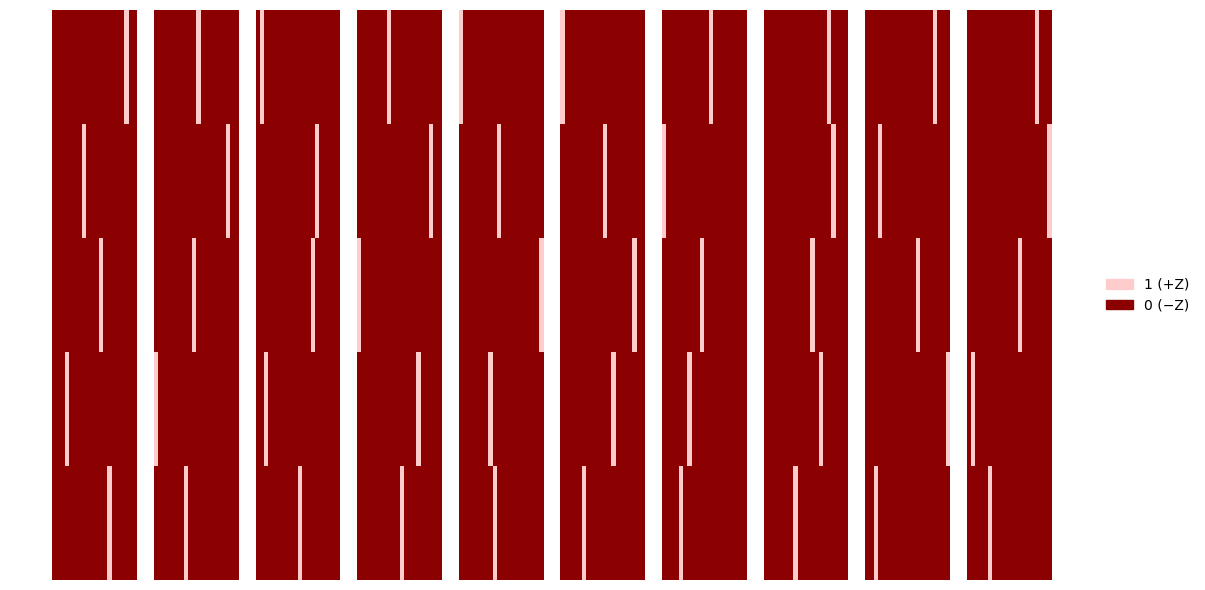

In [5]:
cols = 10
rows = data_subset.shape[0] // cols
panel_width = data_subset.shape[1]
spacer = 4
left_padding = 10
right_padding = 10

canvas_width = (left_padding + cols * panel_width + (cols - 1) * spacer + right_padding)

bright_red = "darkred"
dark_red = "#ffcccc"
flip_red_cmap = ListedColormap([bright_red, dark_red])
flip_red_cmap.set_bad("white")

canvas = np.full((rows, canvas_width), np.nan, dtype=np.float32)
for i in range(cols):
    start_x = left_padding + i * (panel_width + spacer)
    block = data_subset[i * rows:(i + 1) * rows, :]
    canvas[:, start_x:start_x + panel_width] = block

plt.figure(figsize=(12, 6))
img = plt.imshow(canvas, cmap=flip_red_cmap, interpolation='nearest', aspect='auto')
plt.axis('off')

dark_patch = mpatches.Patch(color=dark_red, label="1 (+Z)")
bright_patch = mpatches.Patch(color=bright_red, label="0 (−Z)")
plt.legend(
    handles=[dark_patch, bright_patch],
    loc="center right",
    bbox_to_anchor=(1.1, 0.5),
    frameon=False
)

plt.tight_layout()
plt.show()

In [6]:
class DataLoader:
    def __init__(self, dataset, batch_size=128, shuffle=True, drop_last=False):
        self.x         = dataset
        self.bs        = batch_size
        self.shuffle   = shuffle
        self.drop_last = drop_last

        n_samples = len(self.x)
        self.idx_slices = [
            (i, i + batch_size)
            for i in range(0, n_samples, batch_size)
            if not drop_last or i + batch_size <= n_samples
        ]

    def __iter__(self):
        order = np.arange(len(self.x))
        if self.shuffle:
            np.random.shuffle(order)
        for s, e in self.idx_slices:
            yield self.x[order[s:e]]

    def __len__(self):
        return len(self.idx_slices)

In [7]:
batch_size    = 128
n_vis         = 20
n_hid         = 20
k_steps       = 100
lr            = 1e-3
num_epochs    = 100
pcd_reset     = 1
weight_decay  = 1e-5
lr_decay      = 0.95

rng           = PRNGKey(0)
loader        = DataLoader(data_subset, batch_size, shuffle=True)

lr_sched      = optax.exponential_decay(lr, len(loader), decay_rate=lr_decay, staircase=True)
#opt           = optax.adam(lr_sched)

opt = optax.chain(
    optax.add_decayed_weights(1e-4),   # weight_decay = 10⁻⁴
    optax.adam(lr_sched),
)

rbm           = RBM(n_visible=n_vis, n_hidden=n_hid, k=k_steps)

dummy         = data_subset[:batch_size]
rng, sk       = jax.random.split(rng)
v_pers        = jax.random.bernoulli(sk, .5, shape=dummy.shape).astype(jnp.float32)
params        = rbm.init(rng, dummy, v_pers, rng)["params"]
state         = RBMTrainState.create(apply_fn=rbm.apply, params=params, tx=opt)

#init_b  = np.full((n_vis,), np.log(0.05/0.95), dtype=np.float32)    # b_i = log(p/(1−p)) ≃ −2.94
#init_W  = 0.01*np.random.randn(n_vis, n_hid).astype(np.float32)
#init_c  = np.zeros((n_hid,), dtype=np.float32)
#params  = {"W": init_W, "b": init_b, "c": init_c}
#state   = RBMTrainState.create(apply_fn=rbm.apply, params=params, tx=opt)


state, metrics, rng = train_rbm(state,
                                loader,
                                num_epochs,
                                rng,
                                pcd_reset=pcd_reset,
                                scheduler=lr_sched)

Epoch [1/100] – FE-loss: 0.0141
Epoch [2/100] – FE-loss: -0.0784
Epoch [3/100] – FE-loss: -0.1799
Epoch [4/100] – FE-loss: -0.2549
Epoch [5/100] – FE-loss: -0.3427
Epoch [6/100] – FE-loss: -0.4392
Epoch [7/100] – FE-loss: -0.5047
Epoch [8/100] – FE-loss: -0.5518
Epoch [9/100] – FE-loss: -0.6209
Epoch [10/100] – FE-loss: -0.6460
Epoch [11/100] – FE-loss: -0.7506
Epoch [12/100] – FE-loss: -0.7690
Epoch [13/100] – FE-loss: -0.7813
Epoch [14/100] – FE-loss: -0.8842
Epoch [15/100] – FE-loss: -0.8885
Epoch [16/100] – FE-loss: -1.0136
Epoch [17/100] – FE-loss: -1.0263
Epoch [18/100] – FE-loss: -1.0745
Epoch [19/100] – FE-loss: -1.0424
Epoch [20/100] – FE-loss: -1.0724
Epoch [21/100] – FE-loss: -1.1254
Epoch [22/100] – FE-loss: -1.1209
Epoch [23/100] – FE-loss: -1.1484
Epoch [24/100] – FE-loss: -1.2441
Epoch [25/100] – FE-loss: -1.2418
Epoch [26/100] – FE-loss: -1.2082
Epoch [27/100] – FE-loss: -1.2986
Epoch [28/100] – FE-loss: -1.2827
Epoch [29/100] – FE-loss: -1.2285
Epoch [30/100] – FE-loss

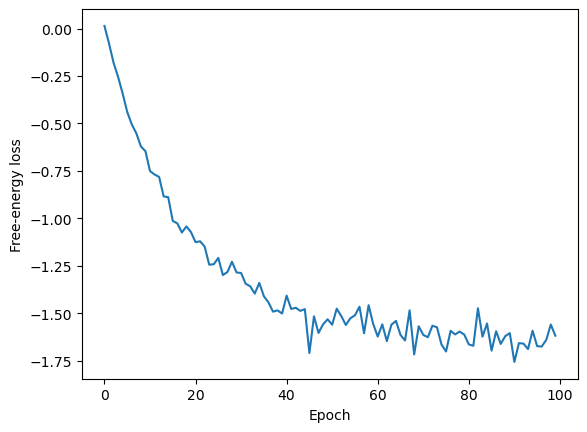

In [8]:
plt.plot([metrics[e]['free_energy_loss'] for e in metrics])
plt.xlabel("Epoch"); plt.ylabel("Free-energy loss"); plt.show()

In [9]:
num_samples = 1000
gibbs_steps = 100

# sched = get_cosine_schedule(4.0, .4, gibbs_steps)
#sched = jnp.linspace(4.0, 0.4, gibbs_steps)
sched = jnp.ones(500) * 0.4

samples = rbm.generate(params=state.params, n_samples=num_samples, T_schedule=sched, rng=rng)

rel_freq = samples.mean(axis=0)
rel_freq

Array([0.37800002, 0.41200003, 0.38500002, 0.39000002, 0.37600002,
       0.40500003, 0.393     , 0.38500002, 0.38200003, 0.381     ,
       0.404     , 0.379     , 0.402     , 0.38500002, 0.36600003,
       0.39900002, 0.407     , 0.40100002, 0.42000002, 0.35700002],      dtype=float32)

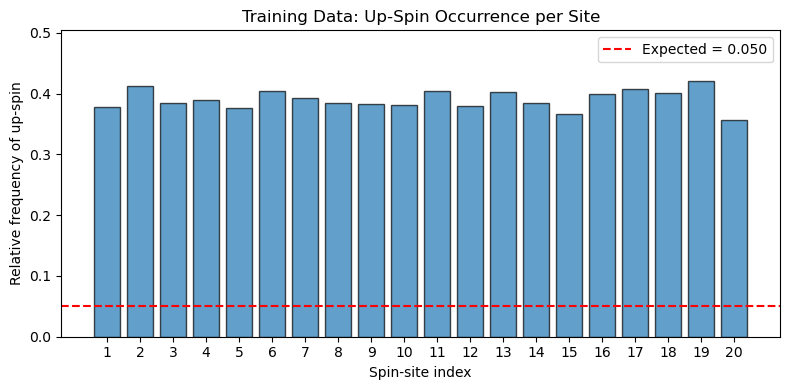

In [10]:
fig, ax = plt.subplots(figsize=(8,4))
sites = np.arange(1, n_vis+1)
ax.bar(sites, rel_freq, width=0.8, edgecolor='black', alpha=0.7)
ax.axhline(1/n_vis, color='red', linestyle='--', label=f'Expected = {1/n_vis:.3f}')

ax.set_xlabel('Spin‐site index')
ax.set_ylabel('Relative frequency of up‐spin')
ax.set_title('Training Data: Up‐Spin Occurrence per Site')
ax.set_xticks(sites)
ax.set_ylim(0, rel_freq.max()*1.2)

ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [32]:
# save the model
model_name = f"rbm_w_vanilla_{n_vis}_{num_train_samples}.pkl"

with open(model_dir / model_name, "wb") as f:
    pickle.dump({"params": state.params}, f)

In [14]:
# ──────────────────────────────────────────────────────────────────────────────
# Hyperparameter sweep INCLUDING train‐time temperature (with monkey patch)
# ──────────────────────────────────────────────────────────────────────────────

import itertools, numpy as np, pandas as pd
import jax, jax.numpy as jnp
from jax.random import PRNGKey
import optax

# assume DataLoader, RBM, RBMTrainState, train_step, data are defined above

# save original sampler
_orig_sample = RBM._gibbs_sample

def violation_rate(samples):
    return np.mean(np.sum(np.array(samples), axis=1) != 1)

param_grid = {
    "k":   [20, 50],
    "lr":  [5e-4, 1e-3],
    "wd":  [0.0, 1e-4],
    "Ttr": [1.0, 0.8, 0.6, 0.4],
}

results = []
for k, lr, wd, Ttr in itertools.product(*param_grid.values()):
    print(f"\n▶︎ k={k}, lr={lr}, wd={wd}, T_train={Ttr}")

    # 1) patch in train‐time T
    RBM._gibbs_sample = staticmethod(
        lambda params, v0, rng, k: _orig_sample(params, v0, rng, k, Ttr)
    )

    # 2) build loader, optimizer, model, state (with bias override)
    batch_size = 256
    loader     = DataLoader(data, batch_size, shuffle=True)
    lr_sched   = optax.exponential_decay(lr, len(loader), 0.95, staircase=True)
    opt        = optax.chain(optax.add_decayed_weights(wd), optax.adam(lr_sched))

    rbm = RBM(n_visible=20, n_hidden=20, k=k)
    rng = PRNGKey(0)
    # init + bias override
    dummy = data[:batch_size]
    rng, sub = jax.random.split(rng)
    v0  = jax.random.bernoulli(sub, 0.5, dummy.shape).astype(jnp.float32)
    vars   = rbm.init(rng, dummy, v0, rng)
    params = vars["params"]
    import flax
    ps     = flax.core.unfreeze(params)
    ps["b"] = np.full((20,), np.log(1/19), dtype=np.float32)
    params = flax.core.freeze(ps)
    state  = RBMTrainState.create(rbm.apply, params, opt)

    # 3) train (fully persistent)
    # init v_pers once per epoch inside train_rbm
    state, _, rng = train_rbm(state, loader, 20, rng, pcd_reset=None)

    # 4) sample & evaluate
    T_sched = jnp.ones(500) * 0.4
    samples = rbm.generate(state.params, 5000, T_sched, rng)
    viol    = violation_rate(samples)
    margerr = np.max(np.abs(np.array(samples).mean(0) - 1/20))
    print(f" → viol={viol:.4f}, max_margerr={margerr:.4f}")

    results.append({"k":k, "lr":lr, "wd":wd, "Ttr":Ttr,
                    "viol":viol, "merr":margerr})

    # restore sampler for next run
    RBM._gibbs_sample = _orig_sample

# display top results
df = pd.DataFrame(results).sort_values(["viol","merr"]).reset_index(drop=True)
print("\nTop 5 configs:\n", df.head())


▶︎ k=20, lr=0.0005, wd=0.0, T_train=1.0


TypeError: create() takes 1 positional argument but 4 were given